# Define the data type of the features

In [ ]:
import tensorflow as tf
import os
import struct                                                                   
import numpy as np                                                              
import matplotlib.pyplot as plt                                                 
from PIL import Image
#https://medium.com/%E8%BB%9F%E9%AB%94%E4%B9%8B%E5%BF%83/%E9%81%A9%E5%90%88%E5%A4%A7%E9%87%8F%E8%B3%87%E6%96%99i-o%E7%9A%84%E5%84%B2%E5%AD%98%E6%A0%BC%E5%BC%8F-tfrecord%E7%B0%A1%E4%BB%8B%E8%88%87%E6%93%8D%E4%BD%9C%E6%95%99%E5%AD%B8-cd27e50d51ee

# mnist one example consists of 28*28 byte + 1 byte
# if _bytes_feature's args is alreaddy a list, no need to use []
def _image_feature(value):
    """"Returns a uint8(byte)_list from a byte."""
    if isinstance(value, type(tf.constant(0))):
        # BytesList won't unpack a string from an EagerTensor.
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _label_feature(value):
    """Returns a uint8(byte)_list from a byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_example(_label, _image):
    feature = {
        "label": _label_feature(_label),
        "image": _image_feature(_image),
        }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString() 

# Construct the TFRecord from the dataset

In [2]:
""" """
# the whole image is a byte feature, not a byte list
import os
import struct                                                                   
import numpy as np                                                              
import matplotlib.pyplot as plt
from OffsetTableBuilder import OffsetTableBuilder
from PIL import Image

# raw data directory
images_file_name = './train-images.idx3-ubyte'
labels_file_name = './train-labels.idx1-ubyte'
images_dir = './mnist jpeg/'

# start reading the raw data
mnist_images=open(images_file_name,'rb')
mnist_labels=open(labels_file_name,'rb')
# skip header file
_=mnist_images.read(16)
_=mnist_labels.read(8)

# data
# build offset_table while writing TFRecords, int64 for offset of each instance, e.g. offset of instance #100 is 100*8B=800B
# byte is little endian

# output data (TFRecord, offset table) directory
tfr_filename="mnist_sparse_padded_class.tfrecords"
oft_filename="mnist-sparse_padded_calss-offset_table"

with tf.io.TFRecordWriter(tfr_filename) as writer:
    # page size=4KB, padding to write to another page if the next instance exceeds the page
    
    """padding needs to ne slightly modified: because padded record needs at least 16B, 
    instead of see if after_ptr exceeds, see if after_ptr+16 exceeds """
    oftbuilder=OffsetTableBuilder(tfr_filename,padding=True)
    for i in range (60000):
        # current tfr file ptr = current_filesize
        with open(images_dir+str(i)+'.jpg','rb') as f:
            buf=mnist_labels.read(1)
            _label=buf
            img_bytes=f.read()            
            serialized_example = serialize_example(_label, img_bytes)
            oftbuilder.calc_offset(serialized_example,writer)
            if(i%4000==0):
                print(i,end=' ')
            writer.write(serialized_example)
    oftbuilder.write(oft_filename)
mnist_images.close()
mnist_labels.close()

0 4000 8000 12000 16000 20000 24000 28000 32000 36000 40000 44000 48000 52000 56000 

# Cells below tests the correctness of the outputted TFRecord and offset table.

In [1]:
""" the read() function """

def sparse_random_read(binfile, oft, idx):
    # read offset, 8B per instance
    #TODO: oft should be loaded to mem
    oft.seek(idx*8,0)
    tmp=oft.read(8)
    offset=struct.unpack("<Q",tmp)[0]
    print("offset=",offset)
    
    # read data length
    binfile.seek(offset,0)
    tmp=binfile.read(8)
    length=struct.unpack("<Q",tmp)[0]
    print("length=",length)
    # we already read first 8B
    record_l_from_col2=length+8
    
    # random read
    tmp=binfile.read(record_l_from_col2)
    r_data=tmp[4:-4]

    # deserialize data
    parsed_features = _parse_function(r_data)
    return parsed_features
    
    

offset= 2475
length= 627
tf.Tensor(b'\t', shape=(), dtype=string)


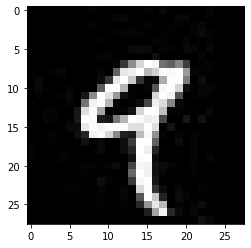

In [17]:
""" test read() function """

binfile=open('mnist_sparse_padded.tfrecords','rb')
oftfile=open('mnist-sparse_padded-offset_table','rb')
parsed_feature=sparse_random_read(binfile,oftfile, 4)
image=tf.io.decode_jpeg(parsed_feature['image'])
print(parsed_feature['label'])
np_image=np.frombuffer(image, dtype='>B').astype(np.uint8)
plt.imshow(np.asarray(np_image).reshape((28,28)),cmap = plt.cm.gray)                                        
plt.show()

binfile.close()
oftfile.close()